In [ ]:
!git clone https://github.com/marcotcr/lime.git

In [ ]:
!pip install lime

In [3]:
import os,sys

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..'))
    import lime

In [5]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [6]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

# преобразование массива данных для корректного определения цвета
# ошибка в импорте заключается в получении поля mnist.data.values
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.values.reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
# функция для демонстрации символов
def show_image_no(image_no):
  fig, ax1 = plt.subplots(1,1)
  ax1.imshow(X_vec[image_no], interpolation = 'none')
  ax1.set_title('Digit: {}'.format(y_vec[0]))

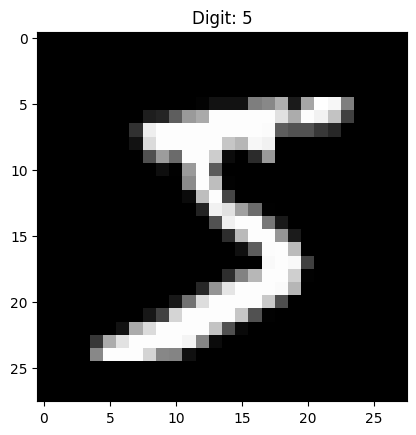

In [8]:
show_image_no(12)

In [9]:
# конвейер для обработки изображений, в котором происходит преобразование иизображений в 1d-векторы, затем используется RandomForest
class PipeStep(object):
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [10]:
# деление выборки и обучение
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, train_size=0.55)
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7f2706cb4550>),
                ('Flatten Image', <__main__.PipeStep object at 0x7f270712ea10>),
                ('RF', RandomForestClassifier())])

In [11]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [38]:
# создание объяснения для определенного изображения из набора, с наложением на исходное изображение и без
def explain(image_no):
  explanation = explainer.explain_instance(X_test[image_no], classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
  fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
  ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
  ax1.set_title('Позитивные регионы для {}'.format(y_test[0]))

  temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
  ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
  ax2.set_title('Позитивные/Негативные регионы для {}'.format(y_test[0]))

  return explanation

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5.55 s, sys: 145 ms, total: 5.7 s
Wall time: 5.86 s


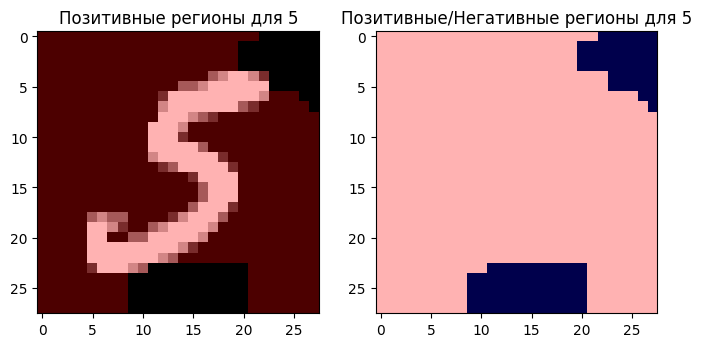

In [39]:
%%time
explanation = explain(0)

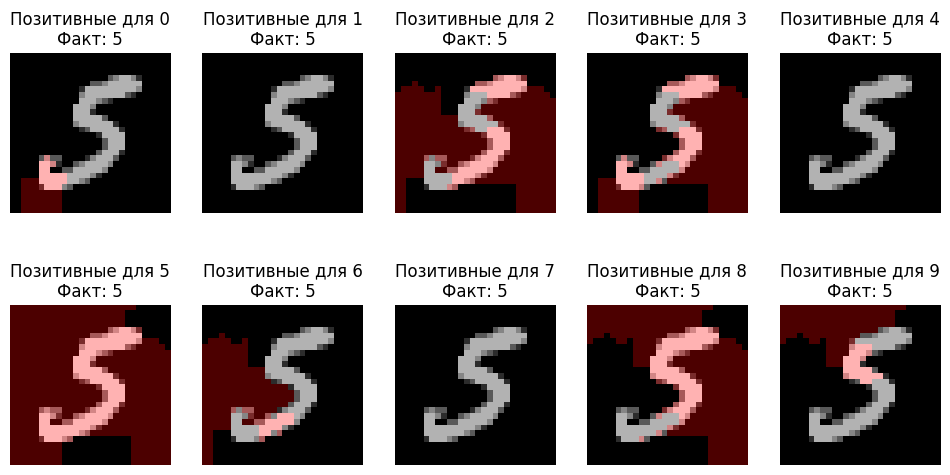

In [41]:
# объяснение для каждого класса
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask, X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Позитивные для {}\nФакт: {}'.format(i, y_test[0]))
    c_ax.axis('off')

In [49]:
# выбор неправильного предсказания из набора
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Номер изображения #{}. Факт: {}, но предсказано {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Номер изображения #27236. Факт: 8, но предсказано 2


In [50]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5.29 s, sys: 95.8 ms, total: 5.39 s
Wall time: 5.48 s


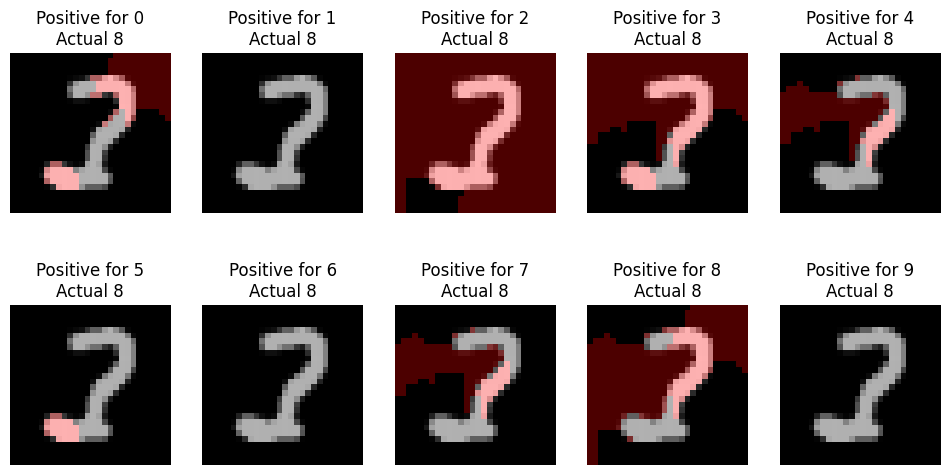

In [51]:
# объяснение для каждого класса
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')

Здесь можно видеть какие конкретно области добавили веса в пользу решения "2". Однако, на данном изображении довольно спорно, какое именно здесь продемонстрировано на самом деле, возможно и "7".

Номер изображения #29180. Факт: 9, но предсказано 6


  0%|          | 0/10000 [00:00<?, ?it/s]

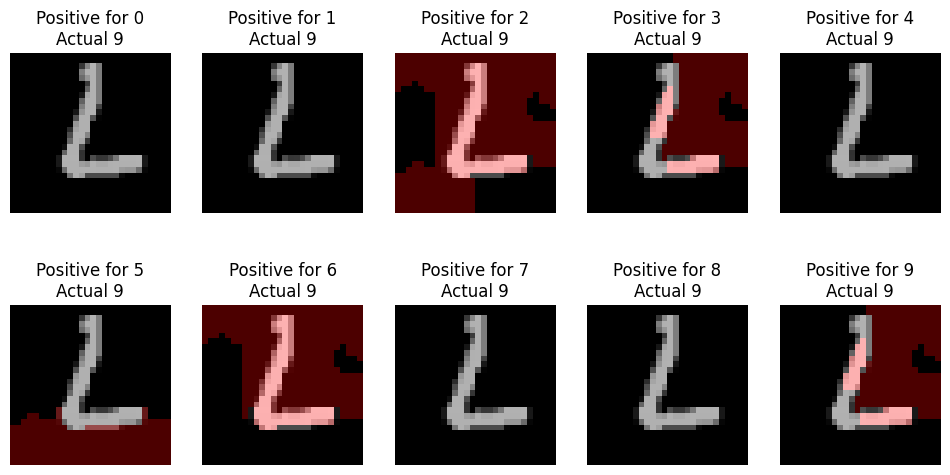

In [55]:
# другой пример
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Номер изображения #{}. Факт: {}, но предсказано {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

# объяснение для каждого класса
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')